<h1 style="text-align: center;" markdown="3">Machine Learning 5: Deep Learning Classifier</h1>

# Table of Contents
[Introduction](#introduction)  
[Data Setup](#data-setup)  
[Deep Learning](#deep-learning)  
[Model Results including Class Balancing, Tuning, CV, and Feature Selection](#all)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

Deep learning is a term used to cover a wide range of models that have grown out of the miltilayer perceptron framework. With applications in computer vision, natural language processing, autonomous driving, synthetic data generation, and much more, there are new deep learning neural network architectures being introduced all the time.

For the purposes of analyzing our dataset, many of the advanced techniques of deep learning mentioned above are inapplicable.In this notebook we use a widely used and very powerful deep learning package called `keras`.

Keras allows the user to make highly customized network architectures by allowing control of the properties in each layer, beyond just the size. In advanced applications this can mean making a [convolutional layer](http://cs231n.github.io/convolutional-networks/) for image processing or a [memory layer](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for processing sequences such as sentences.

It is also possible to control regularization and normalization properties between layers using `keras`. With our data, for example, we will be making use of a regularization technique called __dropout__, in which nodes are probabilistically removed, or "dropped," throughout the epochs of training. This helps the network avoid overfitting the training data by forcing different representation pathways in the network to emerge.

Keras is a high-level wrapper for other deep learning packages. Specifically, on the backend of this notebook `keras` will be using Google's [TensorFlow](https://www.tensorflow.org/) library. But `keras` can also use [Theano](http://deeplearning.net/software/theano/) or Microsoft's [CNTK](https://github.com/Microsoft/cntk) as a backend. 

For the sake of consistency with the previous notebooks, we'll be taking advantage of the [Keras Scikit-learn API](https://keras.io/scikit-learn-api/), which allows us to call the familiar `.fit()` and  `.predict()` methods, as well as apply hyper parameter grid search. 

## Considerations

We can spend a lot of time playing with architecture of our network to see how different choices impact performance. The [keras documentation](https://keras.io/) is a great place to explore different activation functions, normalization layers, and training optimizers. Here I spent some time mostly to understand how deep learning work. Unfortunately I haven't enough time to make the best model possible.

# Data setup <a class="anchor" id="setup"></a>

First, we load in the standard libraries and inspect the training data. 

In [1]:
# Data importation and manipulation tools
import numpy as np
import pandas as pd
import itertools
import json

# Data visualization tools
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Machine Learning tools
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    log_loss,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)

In [2]:
# load training data 
lcs_train = pd.read_pickle("Data/processed/train.pkl")

# Separate features
X_train = lcs_train.drop(['Persns_wgt', 'sick'], axis=1)
y_train = lcs_train['sick']
w_train = lcs_train['Persns_wgt']

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent sick: {:0.1%} \tPercent non-sick: {:0.1%}' \
        .format(*y_train.value_counts(normalize=True, ascending=True)))

# Load test data
lcs_test = pd.read_pickle("Data/processed/test.pkl")

# Separate features
X_test = lcs_test.drop(['Persns_wgt', 'sick'], axis=1)
y_test = lcs_test['sick']
y_test = np.ravel(y_test)
w_test = lcs_test['Persns_wgt']

# print first 5 rows of data
X_train.head()

Data has 39,075 rows and 236 columns
Percent sick: 15.9% 	Percent non-sick: 84.1%


,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,48,2,0,0,0,0,0,5,3664.148804,400,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,27,0,0,0,0,0,0,4,11451.292500,1250,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,3,1,1,0,0,3,0,6,6066.745258,1000,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,0,1,1,1,0,0,0,3,28007.446415,2620,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,4,3,1,0,0,0,0,7,1727.626033,285,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Standardize features
def standardize(df):
    cols = df.loc[:, df.dtypes != 'uint8'].columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field] - mean != 0):
            df.loc[:, field] = (df[field] - mean) / std
    
    return df

standardize(X_train)
standardize(X_test)
X_train.head()

,Q14AGE,Q613BED,Q615KITCHEN,Q616BATH,Q617TOILET,Q161APUBATT,Q161APRIVATT,hhsize,expenditure_pcp,pcnetincome,...,Q221DHEALTH__More than adequate,Q224ANOMONEY__Yes,Q224BNOMONEY5__Yes,Q225ASIZE__Yes,Q225BSIZE5__Yes,Q226ASKIP__Yes,Q226BSKIP5__Yes,Q227ALESS__Yes,Q227BLESS5__Yes,SexOfHead__Male
UQNO,,,,,,,,,,,,,,,,,,,,,
920002240000007301,0.955936,-0.414011,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.157885,-0.431979,-0.283026,...,0,0,0,0,0,0,0,0,0,1
417000450000011901,-0.052461,-1.779027,-1.395383,-0.582252,-0.528091,-0.298658,-0.286177,-0.489928,-0.258849,-0.141051,...,0,0,0,0,0,1,0,1,0,1
107002150000030901,-1.204916,-1.096519,0.262655,-0.582252,-0.528091,1.359649,-0.286177,0.174158,-0.378563,-0.182809,...,0,1,0,1,0,1,0,1,0,1
919005240000017601,-1.348973,-1.096519,0.262655,0.617089,-0.528091,-0.298658,-0.286177,-0.821970,0.109240,0.087779,...,0,0,0,0,0,0,0,0,0,1
983000120000022201,-1.156897,0.268497,0.262655,-0.582252,-0.528091,-0.298658,-0.286177,0.506200,-0.475034,-0.302234,...,0,0,0,0,0,0,0,0,0,0


## Metrics functions
Let's also create of functions for the evaluation of models.

In [4]:
# Create the ROC plot function
def plot_roc(y_test, y_pred, y_prob, model, ax, sample_weights=None):
    
    # dictionnary of metrics to calculate
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=sample_weights)
    metrics = {}
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr
    metrics['roc_auc'] = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    
    # Create graph with Legend
    ax= ax
    ax.plot(metrics['fpr'], metrics['tpr'], label='{} AUC = {:0.2f}'.format(model, metrics['roc_auc']))
    
    # Specification of Graph
    ax.set_title('Receiver Operating Characteristic')
    ax.plot([0,1],[0,1],'k--')
    ax.set_xlim([-0.01,1])
    ax.set_ylim([0,1.01])
    ax.legend(loc='lower right')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return

# Create the confusion matrix plot function
# Derived from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_test, y_pred,ax, sample_weight = None):
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred, sample_weight=None)
    # Reverse the results
    cm = cm[::-1,::-1]

    # Create plot
    ax = ax
    tick_marks = np.arange(2)
    ax.set_title('Confusion matrix')
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(["sick", "non-sick"])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(["sick","non-sick"])
    ax.grid(False)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    # Create font and color bar
    im = ax.imshow(cm, interpolation='nearest', cmap= plt.cm.Blues)
    fig.colorbar(im, ax=ax, shrink=0.7)

    # Create normalized and text results
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = "{:.0f}".format(cm[i,j])
        txt = txt + "\n{:0.1%}".format(cm_norm[i,j])
        ax.text(j, i, txt, fontsize=14, fontweight='bold',
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    return


# Create a DataFrame to store de model results
model_score = pd.DataFrame(index = ['accuracy','recall','precision','f1','roc_auc','cross_entropy','cohen_kappa'])

# Define a function to show metrics in a DataFrame
def get_metrics(y_test, y_pred, model_name, sample_weights=None): 
    # Show metrics values
    model_scores = {}

    model_scores['accuracy']          = accuracy_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['recall']            = recall_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['precision']         = precision_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['f1']                = f1_score(y_test, y_pred, sample_weight=sample_weights)
    model_scores['roc_auc']           = roc_auc_score(y_test,y_prob, sample_weight=sample_weights)
    model_scores['cross_entropy']     = log_loss(y_test,y_prob,sample_weight=sample_weights)
    model_scores['cohen_kappa']       = cohen_kappa_score(y_test, y_pred)

    print("Model Scores")
    print("Actual sick rate: {:0.2%}".format(y_test.sum()/len(y_test)))
    print("Predicted sick rate: {:0.2%}".format(y_pred.sum()/len(y_pred)))
    model_score[model_name] = model_score.index.map(model_scores)
    return model_score

# Deep Learning <a class="anchor" id="deep-learning"></a>

Before training our data, we will create a model. As mentionned earlier, I looked at the documentation and use some code snippet from [Machine Learning Mastery](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/) to have some example for a binary classification process. I also use the layers sequence example of this [article](https://www.pluralsight.com/guides/classification-keras) to create my own model.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier


# Create the model (layers)
def create_model(input_dim=None, hidden_layer_sizes=None, keep_prob=1.0, dropout_layers=None):

    if hidden_layer_sizes is None:
        # make simple two layer network
        hidden_layer_sizes = np.ceil(np.sqrt(input_dim))
    
    # create model
    model = Sequential()
    for i,layer_size in enumerate(hidden_layer_sizes):
        if i==0:
            # include input_dim specification
            model.add(Dense(layer_size, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(layer_size, activation='relu'))
            if dropout_layers == 'all':
                model.add(Dropout(keep_prob))
    
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.model.summary())
    return model

Using TensorFlow backend.


In [6]:
input_dim = X_train.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)
# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train.as_matrix(), y_train)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 236)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 700)               165900    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              717824    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
den

In [7]:
# Get an initial score
%time score = model.score(X_train.as_matrix(), y_train)
print("In-sample score: {:0.2%}".format(score))

  190/39075 [..............................] - ETA: 38s 

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


39075/39075 [==============================] - 10s 259us/step
CPU times: user 31.9 s, sys: 32.7 s, total: 1min 4s
Wall time: 10.1 s
In-sample score: 84.49%


In [8]:
# Run the model
y_pred = model.predict(X_test.as_matrix())
y_prob = model.predict_proba(X_test.as_matrix())[:,1]

  230/13026 [..............................] - ETA: 8s  

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


  630/13026 [>.............................] - ETA: 3s

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


13026/13026 [==============================] - 3s 243us/step


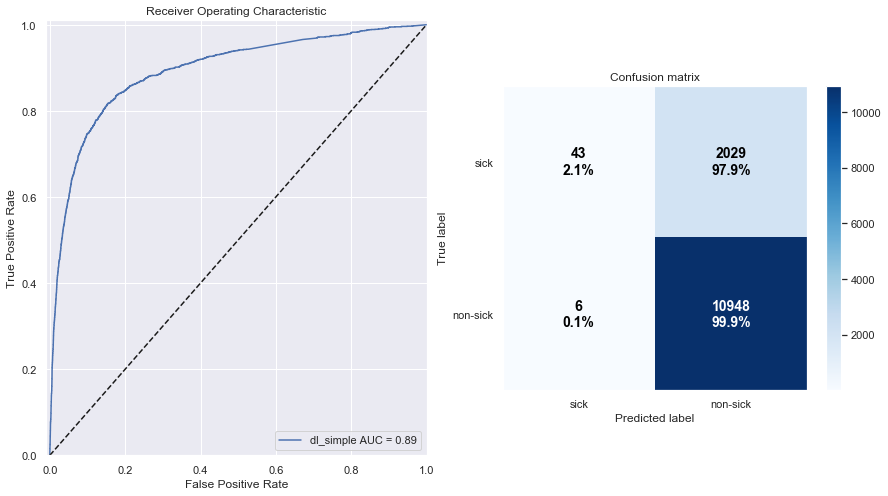

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 0.38%


,dl_simple
accuracy,0.843774
recall,0.020753
precision,0.877551
f1,0.040547
roc_auc,0.892821
cross_entropy,0.340850
cohen_kappa,0.033443


In [9]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "dl_simple", ax= axes[0])
plot_confusion_matrix(y_test, y_pred, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred, 'dl_simple')

It appears that the deep learning network in this case is highly affected by the unbalanced classes, so it is essentially predicting almost as non-sick. Deep Learning networks typically produce better results when the classes are balanced or weighted, so we will need to apply these techniques with this dataset to get useful results.

## Undersampling 
Let's apply undersampling and see how the performance is affected.

In [10]:
from imblearn.under_sampling import RandomUnderSampler

cols = X_train.columns

# Apply random undersampling
X_train_u, y_train_u = RandomUnderSampler().fit_sample(X_train, y_train)
X_train_u = pd.DataFrame(X_train_u, columns=cols)
print("X shape after undersampling: ", X_train_u.shape)

input_dim = X_train_u.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train_u.as_matrix(), y_train_u)

X shape after undersampling:  (12430, 236)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8_input (InputLayer)   (None, 236)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 700)               165900    
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              717824    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (Non

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Epoch 1/10
12430/12430 [==============================] - 31s 2ms/step - loss: 0.7336 - acc: 0.5197
Epoch 2/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.6255 - acc: 0.7017
Epoch 3/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.5425 - acc: 0.7619
Epoch 4/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.5012 - acc: 0.7894
Epoch 5/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.4712 - acc: 0.8049
Epoch 6/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.4503 - acc: 0.8252
Epoch 7/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.4188 - acc: 0.8399
Epoch 8/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.4002 - acc: 0.8498
Epoch 9/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.3733 - acc: 0.8621
Epoch 10/10
12430/12430 [==============================] - 30s 2ms/step - loss: 0.3623 - acc: 0.8642

In [11]:
# Get an initial score
%time score = model.score(X_train_u.as_matrix(), y_train_u)
print("In-sample score: {:0.2%}".format(score))

   10/12430 [..............................] - ETA: 3:15

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


12430/12430 [==============================] - 3s 266us/step
CPU times: user 10.2 s, sys: 10.4 s, total: 20.6 s
Wall time: 3.31 s
In-sample score: 90.43%


In [12]:
# Run the model
%time y_pred_u = model.predict(X_test.as_matrix())
%time y_prob_u = model.predict_proba(X_test.as_matrix())[:,1]

  220/13026 [..............................] - ETA: 10s 

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


13026/13026 [==============================] - 3s 248us/step
CPU times: user 10.1 s, sys: 10.2 s, total: 20.3 s
Wall time: 3.24 s
13026/13026 [==============================] - 3s 242us/step
CPU times: user 10 s, sys: 10.2 s, total: 20.2 s
Wall time: 3.15 s


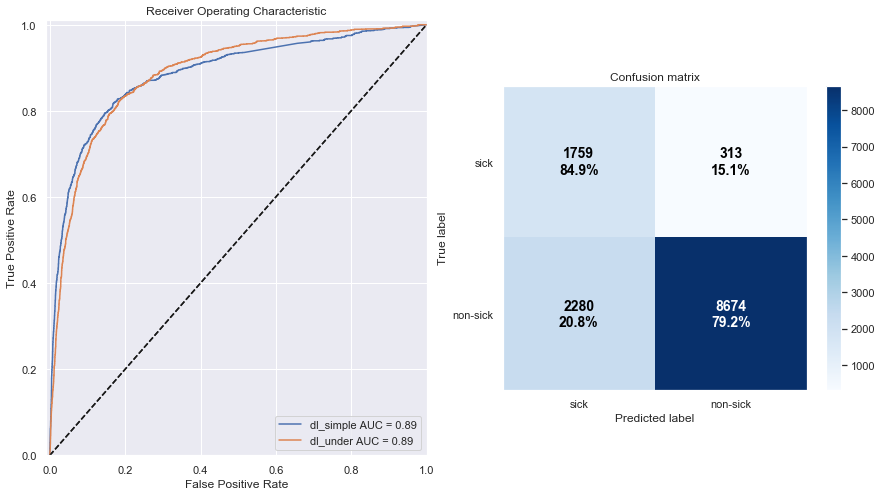

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 31.01%


,dl_simple,dl_under
accuracy,0.843774,0.794969
recall,0.020753,0.841109
precision,0.877551,0.393189
f1,0.040547,0.535875
roc_auc,0.892821,0.886711
cross_entropy,0.340850,0.329534
cohen_kappa,0.033443,0.462709


In [13]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "dl_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "dl_under", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_u, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_u, 'dl_under', sample_weights = w_test)

Undersampling increase significantly the recall to have one of the best recall of all models. But the accuracy is very poor. It is even less than our baseline. We know that deep learning models require a lot of datapoints. Let's try the overSampling Method.

# Oversampling

In [14]:
from imblearn.over_sampling import SMOTE

# Apply oversampling with SMOTE
X_train_o, y_train_o = SMOTE().fit_sample(X_train, y_train)
X_train_o = pd.DataFrame(X_train_o, columns=cols)
print("X shape after oversampling: ", X_train.shape)

input_dim = X_train_o.shape[1]
hidden_layer_sizes = (700, 1024, 512, 256, 128, 64)

# Fit the model
model = KerasClassifier(build_fn=create_model, 
                        input_dim=input_dim, 
                        hidden_layer_sizes=hidden_layer_sizes,
                        keep_prob=0.7,
                        dropout_layers='all',
                        epochs=10, 
                        batch_size=10, 
                        verbose=1)

%time model.fit(X_train_o.as_matrix(), y_train_o)

X shape after oversampling:  (39075, 236)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15_input (InputLayer)  (None, 236)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 700)               165900    
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              717824    
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Epoch 1/10
65720/65720 [==============================] - 160s 2ms/step - loss: 0.5191 - acc: 0.7554
Epoch 2/10
65720/65720 [==============================] - 158s 2ms/step - loss: 0.3644 - acc: 0.8683
Epoch 3/10
65720/65720 [==============================] - 158s 2ms/step - loss: 0.3314 - acc: 0.8852
Epoch 4/10
65720/65720 [==============================] - 158s 2ms/step - loss: 0.3084 - acc: 0.8937
Epoch 5/10
65720/65720 [==============================] - 158s 2ms/step - loss: 0.2972 - acc: 0.9008
Epoch 6/10
65720/65720 [==============================] - 161s 2ms/step - loss: 0.2942 - acc: 0.9036
Epoch 7/10
65720/65720 [==============================] - 159s 2ms/step - loss: 0.2872 - acc: 0.9071
Epoch 8/10
65720/65720 [==============================] - 159s 2ms/step - loss: 0.2913 - acc: 0.9098
Epoch 9/10
65720/65720 [==============================] - 159s 2ms/step - loss: 0.2711 - acc: 0.9164
Epoch 10/10
65720/65720 [==============================] - 159s 2ms/step - loss: 0.2828 - a

In [15]:
# Get an initial score
%time score = model.score(X_train_o.as_matrix(), y_train_o)
print("In-sample score: {:0.2%}".format(score))

   10/65720 [..............................] - ETA: 19:48

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


65720/65720 [==============================] - 17s 259us/step
CPU times: user 53.5 s, sys: 55 s, total: 1min 48s
Wall time: 17 s
In-sample score: 90.60%


In [16]:
# Run the model
%time y_pred_o = model.predict(X_test.as_matrix())
%time y_prob_o = model.predict_proba(X_test.as_matrix())[:,1]

   10/13026 [..............................] - ETA: 3:15

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


13026/13026 [==============================] - 3s 250us/step
CPU times: user 10.2 s, sys: 10.2 s, total: 20.3 s
Wall time: 3.27 s
13026/13026 [==============================] - 3s 242us/step
CPU times: user 10 s, sys: 10.3 s, total: 20.3 s
Wall time: 3.16 s


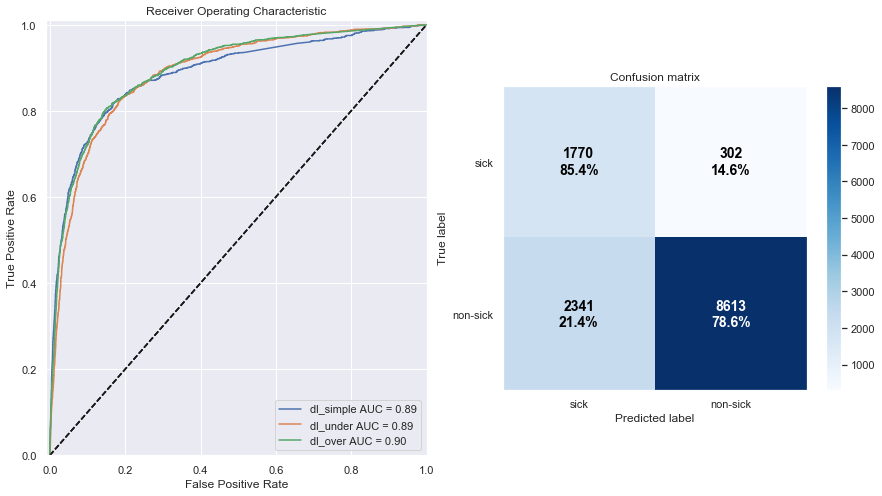

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 31.56%


,dl_simple,dl_under,dl_over
accuracy,0.843774,0.794969,0.795630
recall,0.020753,0.841109,0.844084
precision,0.877551,0.393189,0.394349
f1,0.040547,0.535875,0.537556
roc_auc,0.892821,0.886711,0.886711
cross_entropy,0.340850,0.329534,0.329534
cohen_kappa,0.033443,0.462709,0.457863


In [17]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "dl_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "dl_under", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "dl_over", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_o, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_o, 'dl_over', sample_weights = w_test)

Oversampling did not help get better results. Although we have good Recall, the accuracy is still worse than our baseline. We essentially predict too many individuals as sick. Let's try to tune some parameters and use cross-validation with undersampling and try to get better results. 

NOTE: Here I didn't use the oversampling method because of time, but I would have done this if it was not only for educational purpose.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

In [24]:
from sklearn.model_selection import GridSearchCV

input_dim = X_train_u.shape[1]
# build the model
estimator = KerasClassifier(build_fn=create_model, 
                            input_dim=input_dim, 
                            dropout_layers='all',
                            epochs=10,
                            verbose=1)
parameters = {'hidden_layer_sizes': [(700, 1024, 512, 256, 128, 64)],
              'keep_prob': [0.5, 0.6],
              'batch_size': [128, 256]
             }

model = GridSearchCV(estimator, parameters, verbose=3, cv=3)
%time model.fit(X_train_u.as_matrix(), y_train_u)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] batch_size=128, hidden_layer_sizes=(700, 1024, 512, 256, 128, 64), keep_prob=0.5 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281_input (InputLayer) (None, 236)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 700)               165900    
_________________________________________________________________
dense_282 (Dense)            (None, 1024)              717824    
_________________________________________________________________
dropout_201 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_283 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_202 (Dropout)        (None, 512)               0     

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s remaining:    0.0s


Epoch 1/10
8287/8287 [==============================] - 6s 748us/step - loss: 0.6238 - acc: 0.6578
Epoch 2/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.4936 - acc: 0.7891
Epoch 3/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.4429 - acc: 0.8165
Epoch 4/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.3995 - acc: 0.8412
Epoch 5/10
8287/8287 [==============================] - 3s 348us/step - loss: 0.3571 - acc: 0.8610
Epoch 6/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.2806 - acc: 0.8959
Epoch 7/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.2287 - acc: 0.9149
Epoch 8/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.1747 - acc: 0.9362
Epoch 9/10
8287/8287 [==============================] - 3s 348us/step - loss: 0.1443 - acc: 0.9473
Epoch 10/10
8287/8287 [==============================] - 1s 70us/step
[CV]  batch_size=128, hidden_layer_size

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Epoch 1/10
8287/8287 [==============================] - 6s 756us/step - loss: 0.5299 - acc: 0.7421
Epoch 2/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.4251 - acc: 0.8250
Epoch 3/10
8287/8287 [==============================] - 3s 359us/step - loss: 0.3763 - acc: 0.8546
Epoch 4/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.3334 - acc: 0.8750
Epoch 5/10
8287/8287 [==============================] - 3s 352us/step - loss: 0.2845 - acc: 0.8906
Epoch 6/10
8287/8287 [==============================] - 3s 352us/step - loss: 0.2383 - acc: 0.9108
Epoch 7/10
8287/8287 [==============================] - 3s 349us/step - loss: 0.1864 - acc: 0.9319
Epoch 8/10
8287/8287 [==============================] - 3s 355us/step - loss: 0.1509 - acc: 0.9444
Epoch 9/10
8287/8287 [==============================] - 3s 351us/step - loss: 0.1282 - acc: 0.9537
Epoch 10/10
8287/8287 [==============================] - 1s 70us/step
[CV]  batch_size=128, hidden_layer_size

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.3min finished


Epoch 1/10
12430/12430 [==============================] - 7s 583us/step - loss: 0.7037 - acc: 0.5385
Epoch 2/10
12430/12430 [==============================] - 3s 244us/step - loss: 0.5622 - acc: 0.7281
Epoch 3/10
12430/12430 [==============================] - 3s 248us/step - loss: 0.4894 - acc: 0.7901
Epoch 4/10
12430/12430 [==============================] - 3s 256us/step - loss: 0.4538 - acc: 0.8129
Epoch 5/10
12430/12430 [==============================] - 3s 259us/step - loss: 0.4157 - acc: 0.8331
Epoch 6/10
12430/12430 [==============================] - 3s 253us/step - loss: 0.3739 - acc: 0.8564
Epoch 7/10
12430/12430 [==============================] - 3s 265us/step - loss: 0.3125 - acc: 0.8848
Epoch 8/10
12430/12430 [==============================] - 3s 265us/step - loss: 0.2586 - acc: 0.9093
Epoch 9/10
12430/12430 [==============================] - 3s 251us/step - loss: 0.2143 - acc: 0.9230
Epoch 10/10
12430/12430 [==============================] - 3s 255us/step - loss: 0.1736 - a

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9afa691e10>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(700, 1024, 512, 256, 128, 64)], 'keep_prob': [0.5, 0.6], 'batch_size': [128, 256]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [25]:
# Get an initial score
%time score = model.score(X_train_u.as_matrix(), y_train_u)
print("In-sample score: {:0.2%}".format(score))

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


12430/12430 [==============================] - 2s 177us/step
CPU times: user 4.26 s, sys: 1.06 s, total: 5.32 s
Wall time: 2.2 s
In-sample score: 95.45%


In [26]:
# Run the model
%time y_pred_cv = model.predict(X_test.as_matrix())
%time y_prob_cv = model.predict_proba(X_test.as_matrix())[:,1]

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


13026/13026 [==============================] - 2s 158us/step
CPU times: user 4.22 s, sys: 1.11 s, total: 5.33 s
Wall time: 2.07 s
13026/13026 [==============================] - 1s 50us/step
CPU times: user 2.84 s, sys: 1.09 s, total: 3.93 s
Wall time: 652 ms


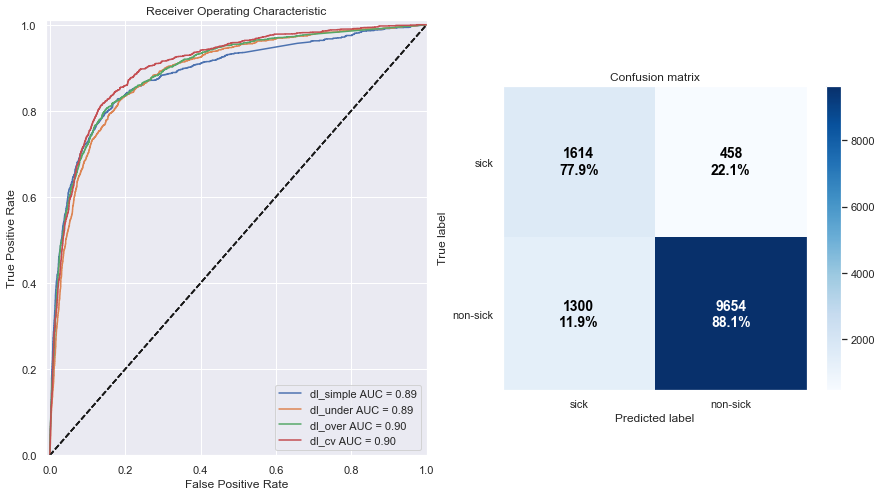

Model Scores
Actual sick rate: 15.91%
Predicted sick rate: 22.37%


,dl_simple,dl_under,dl_over,dl_cv
accuracy,0.843774,0.794969,0.795630,0.874002
recall,0.020753,0.841109,0.844084,0.754648
precision,0.877551,0.393189,0.394349,0.537247
f1,0.040547,0.535875,0.537556,0.627656
roc_auc,0.892821,0.886711,0.886711,0.886711
cross_entropy,0.340850,0.329534,0.329534,0.329534
cohen_kappa,0.033443,0.462709,0.457863,0.566884


In [27]:
# Show plot of metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))
plot_roc(y_test, y_pred, y_prob, "dl_simple", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_u, y_prob_u, "dl_under", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_o, y_prob_o, "dl_over", ax= axes[0], sample_weights= w_test)
plot_roc(y_test, y_pred_cv, y_prob_cv, "dl_cv", ax= axes[0], sample_weights= w_test)
plot_confusion_matrix(y_test, y_pred_cv, ax= axes[1])
plt.show()
get_metrics(y_test, y_pred_cv, 'dl_cv', sample_weights = w_test)

The cross-validation and parameter tuning helps to increase the performance. It has the best accuracy for deep learning and has also the best f1 (function of recall and precision).

Let's see if there is over or underfitting with the different parameters.

In [28]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 
        'std_test_score', 
        'mean_train_score',
        'std_train_score', 
        'param_hidden_layer_sizes',
        'param_keep_prob', 
        'param_batch_size']
cv_results[cols].sort_values('mean_test_score', ascending=False)

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_hidden_layer_sizes,param_keep_prob,param_batch_size
3,0.770475,0.041892,0.943685,0.008226,"(700, 1024, 512, 256, 128, 64)",0.6,256
0,0.754948,0.058514,0.982180,0.006832,"(700, 1024, 512, 256, 128, 64)",0.5,128
1,0.687128,0.096054,0.965326,0.006260,"(700, 1024, 512, 256, 128, 64)",0.6,128
2,0.664843,0.098683,0.973653,0.010099,"(700, 1024, 512, 256, 128, 64)",0.5,256


No handles with labels found to put in legend.


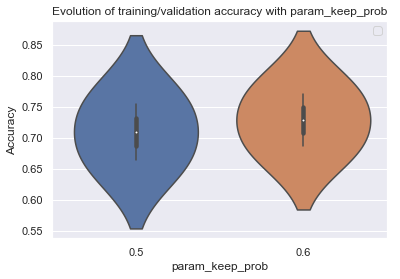

No handles with labels found to put in legend.


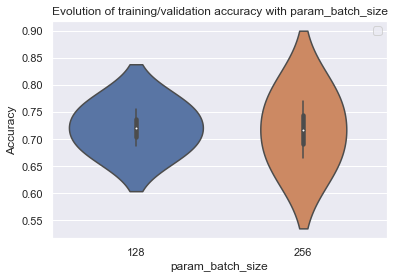

In [39]:
para = ['param_keep_prob', 'param_batch_size']

for p in para:
    sns.violinplot(data=cv_results, x=cv_results[p], y=cv_results["mean_test_score"])
    plt.xlabel(cv_results[p].name)
    plt.ylabel('Accuracy')
    plt.title("Evolution of training/validation accuracy with {}".format(cv_results[p].name))
    plt.legend()
    plt.show()

The keep probability of 0.6 seem to be more accurate and with less variance than the 0.5 keep_prob. For the batch size, the mean accuracy are not so different but the 128 batch size has less variance.

# Deepl Learning Summary <a class="anchor" id="summary"></a>

In [40]:
# Inverse the cross entropy values
model_eval = model_score.copy()
model_eval[model_eval.index == 'cross_entropy'] = 1 - model_eval[model_eval.index == 'cross_entropy']

model_eval.mean().sort_values(ascending = False)

dl_cv        0.702516
dl_over      0.655237
dl_under     0.655004
dl_simple    0.481148
dtype: float64

In [41]:
# Store the results in a pickle file
model_score.to_pickle("models/dl.pkl")